In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

In [4]:
# Initial exploration
print(train_data.head())  # Checking the first few rows
print("Number of unique classes:", train_data['label'].nunique())  # Unique classes (digits 0-9)
print("Number of pixels:", train_data.shape[1] - 1)  # Number of features (pixels)

# Check for missing values
print("Number of missing values:", train_data.isnull().sum().sum())
train_data = train_data.dropna()
# Normalization and Reshaping


X_train = train_data.drop('label', axis=1) / 255.0  # Normalizing pixel values
y_train = train_data['label']

X_test = test_data.drop('label', axis=1) / 255.0
y_test = test_data['label']

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
Number of unique classes: 10
Number of pixels: 784
Number of missing values: 0


In [7]:
# Reshape images permanently in the sets
X_train = X_train.values.reshape(-1, 28, 28, 1)  # Reshaping training set
X_test = X_test.values.reshape(-1, 28, 28, 1)    # Reshaping test set

AttributeError: 'numpy.ndarray' object has no attribute 'values'

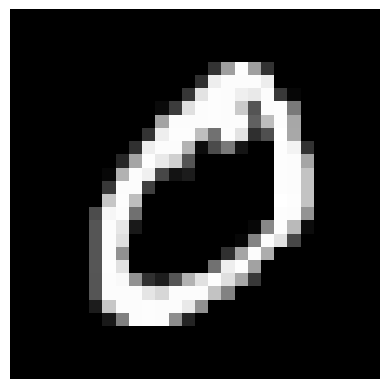

In [47]:
# Reshape images to 28x28 and visualize
def show_image(data, index):
    img = data[index]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

show_image(X_train, 1)  # Display the first image after reshaping

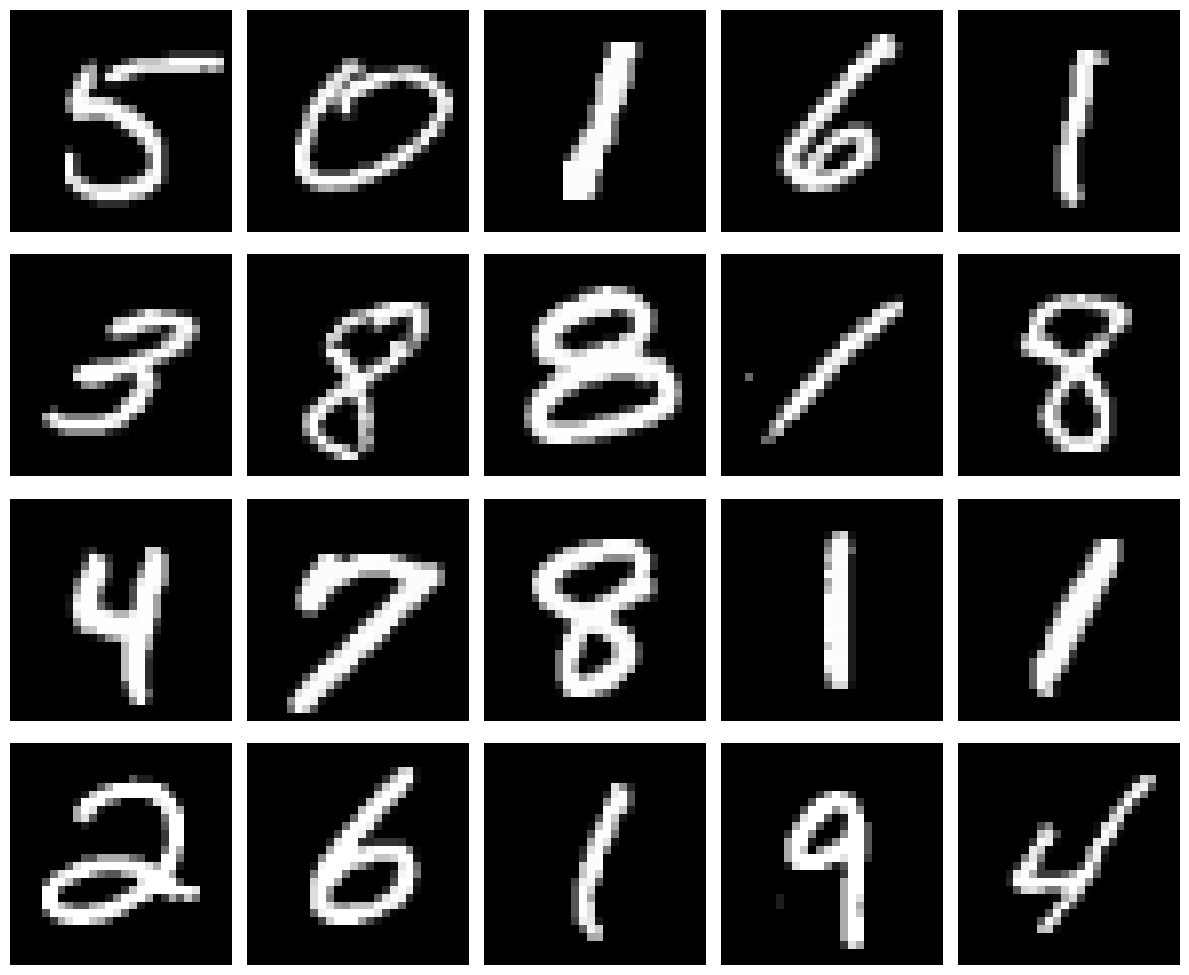

In [48]:
# Splitting training data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Visualize multiple images
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i in range(20):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Initialize K-NN classifier
knn = KNeighborsClassifier()

# Define hyperparameters to tune
params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

# Grid search using cross-validation
grid_search = GridSearchCV(knn, params, cv=5, n_jobs=-1)
grid_search.fit(X_train.reshape(-1, 28 * 28), y_train)

# Get best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.9702291666666667


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Get best number of neighbors and weight
best_n_neighbors = best_params['n_neighbors']
best_weights = best_params['weights']

# Create K-NN model using best parameters
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights)
knn.fit(X_train.reshape(-1, 28 * 28), y_train)

# Predict using the best K-NN model on validation set
knn_val_predictions = knn.predict(X_val.reshape(-1, 28 * 28))

# Calculate accuracy
knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)
print(f"K-NN Validation Accuracy: {knn_val_accuracy}")

K-NN Validation Accuracy: 0.9735833333333334


In [51]:
import tensorflow as tf


# Define different architectures
architectures = [
    {'hidden_neurons': 128, 'learning_rate': 0.001, 'batch_size': 32},
    {'hidden_neurons': 64, 'learning_rate': 0.0001, 'batch_size': 16},
    {'hidden_neurons': 256, 'learning_rate': 0.01, 'batch_size': 64}
]

best_accuracy = 0.0
best_model = None

for config in architectures:
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(config['hidden_neurons'], activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=5, batch_size=config['batch_size'],
                        validation_data=(X_val, y_val))

    # Evaluate on validation set
    _, validation_accuracy = model.evaluate(X_val, y_val)

    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_model = model
    
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(X_val, y_val)
    print(f"Config: Hidden Neurons={config['hidden_neurons']}, Learning Rate={config['learning_rate']}, "
          f"Batch Size={config['batch_size']}")
    print(f"Test Accuracy: {test_acc}\n")

print(f"Best Accuracy: {best_accuracy}")

# Use the best model for further evaluations or predictions


Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2799 - accuracy: 0.9210 - val_loss: 0.1657 - val_accuracy: 0.9530
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1272 - accuracy: 0.9630 - val_loss: 0.1134 - val_accuracy: 0.9666
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0863 - accuracy: 0.9747 - val_loss: 0.1068 - val_accuracy: 0.9694
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0657 - accuracy: 0.9796 - val_loss: 0.0966 - val_accuracy: 0.9706
Epoch 5/5
375/375 [==============================] - 0s 1ms/step - loss: 0.0867 - accuracy: 0.9745
Config: Hidden Neurons=128, Learning Rate=0.001, Batch Size=32
Test Accuracy: 0.9745000004768372

Epoch 1/5
3000/3000 [==============================] - 5s 1ms/step - loss: 0.6718 - accuracy: 0.8282 - val_loss: 0.3561 - val_accuracy: 0.9051
Epoch 2/5
3000/3000 [==============================] - 4s 1ms/step - loss: 0.3170 - accu

In [55]:
ann_accuracy = best_accuracy
if ann_accuracy > knn_val_accuracy:
    final_model = best_model
    print("ann has a higher accuracy")
else:
    final_model = knn
    print("knn has a higher accuracy")



ann has a higher accuracy


In [56]:
# Assuming final_model is either the best ANN model or the best K-NN model based on the comparison of accuracies
# Predict using the final_model on validation set or X_val

# For ANN models
if isinstance(final_model, tf.keras.models.Sequential):
    final_predictions = final_model.predict(X_val.reshape(-1, 28, 28, 1))

# For K-NN models
elif isinstance(final_model, KNeighborsClassifier):
    # Flatten the extra dimension
    X_val_flattened = X_val.reshape(X_val.shape[0], -1)
    final_predictions = final_model.predict(X_val_flattened)

# Convert probabilities to class labels (for ANN models)
if final_predictions.ndim > 1 and final_predictions.shape[1] > 1:
    final_predictions = np.argmax(final_predictions, axis=1)

# Calculate the confusion matrix
conf_matrix_final = confusion_matrix(y_val, final_predictions)
print("Confusion Matrix for Final Model:")
print(conf_matrix_final)







375/375 [==============================] - 0s 1ms/step
Confusion Matrix for Final Model:
[[1160    0    3    0    1    3    3    1    3    1]
 [   0 1301   12    1    1    0    4    2    1    0]
 [   0    4 1149    4    0    0    3   12    1    1]
 [   0    0   19 1161    1   20    0    4    7    7]
 [   1    1    3    0 1152    1    2    2    0   14]
 [   6    0    2    7    2 1074    7    3    2    1]
 [   1    0    1    0    1    2 1171    0    1    0]
 [   1    2    9    1    3    0    0 1281    0    2]
 [   7    6    8   15    4   11   10    6 1085    8]
 [   4    1    0    2    6    5    2   13    1 1160]]


In [8]:
import tensorflow as tf
# Save the best model
# final_model.save('best_model.h5')

# Reload the model
loaded_model = tf.keras.models.load_model('best_model.h5')

# Assuming X_test is loaded from 'mnist_test.csv'
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Test Accuracy of the Best Model: {test_accuracy}")


313/313 [==============================] - 4s 11ms/step - loss: 0.0806 - accuracy: 0.9762
Test Accuracy of the Best Model: 0.9761999845504761
